The purpose of this notebook is to show how to train adapter
models to transform query embeddings based on user feedback.

In this notebook, both queries and feedbacks are generated with the an LLM model. So, this is for demonstration purposes. You may obtain better fitted adapter model with actual user feedback.

You will train a simple adapter model, transform model genenerated queires and see if you can get same, worse or better documents retrieved with the adapted queries.

The leanrned adapter matrix is influenced by the distribution of +ve and -ve labels. So, there is a tendency to transform to one rigon on the embedding space if we have more +ve or -ve labels.

This notebook is adapted from:
https://learn.deeplearning.ai/advanced-retrieval-for-ai/lesson/6/embedding-adaptors

Notebook is created on SageMaker Studio Lab (free)

In [ ]:
%pip install --upgrade --quiet pypdf python-dotenv umap-learn chromadb \
    langchain huggingface_hub sentence-transformers

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
from huggingface_hub import login
_ = load_dotenv(find_dotenv()) # read local .env file
hugging_face_access_token = os.environ['HUGGINGFACEHUB_API_TOKEN']
login(hugging_face_access_token)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/studio-lab-user/.cache/huggingface/token
Login successful


In [2]:
from embedding_utils import load_chroma, word_wrap
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='microsoft_annual_report_2022.pdf',
    collection_name='microsoft_annual_report_2022',
    embedding_function=embedding_function)

chroma_collection.count()

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


349

In [39]:
import numpy as np
from tqdm import tqdm
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

In [41]:
# https://pypi.org/project/umap-learn/
import umap
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|██████████| 349/349 [06:07<00:00,  1.05s/it]


In [4]:
from dataclasses import dataclass

@dataclass
class PlotLayer:
    embedding: list
    size: int = None
    color: str = None
    facecolor: str = None
    edgecolor: str = None
    marker: str = None
    label: str = None

%matplotlib inline
import matplotlib.pyplot as plt

def plot_projections(title, PlotLayers: list[PlotLayer], legend: list[str] = []) -> None:
    plt.figure()
    for PlotLayer in PlotLayers:
        plt.scatter(PlotLayer.embedding[:, 0], PlotLayer.embedding[:, 1],
            s=PlotLayer.size, marker=PlotLayer.marker, color=PlotLayer.color,
            facecolor = PlotLayer.facecolor, edgecolor=PlotLayer.edgecolor)

    plt.gca().set_aspect('equal', 'datalim')
    plt.title(title)
    plt.axis('off')
    if len(legend) > 0:
        plt.legend(legend)

In [5]:
import llm_utils
llm = llm_utils.HuggingFaceHub(
    repo_id="HuggingFaceH4/zephyr-7b-beta",
    task="text-generation",
    model_kwargs={
        "max_new_tokens": 512,
        "top_k": 30,
        "temperature": 0.1,
        "repetition_penalty": 1.03,
    },
)

chat_model = llm_utils.ChatHuggingFace(llm=llm)

WARNING! repo_id is not default parameter.
                    repo_id was transferred to model_kwargs.
                    Please confirm that repo_id is what you intended.
WARNING! task is not default parameter.
                    task was transferred to model_kwargs.
                    Please confirm that task is what you intended.
WARNING! huggingfacehub_api_token is not default parameter.
                    huggingfacehub_api_token was transferred to model_kwargs.
                    Please confirm that huggingfacehub_api_token is what you intended.


In [6]:
from langchain.schema import HumanMessage, SystemMessage
from langchain.prompts import ChatPromptTemplate
def generate_queries(chat_model):

    system_message = """
        You are a helpful expert financial research assistant.
        You help users analyze financial statements to better
        understand companies. Suggest 10 to 16 short questions that
        are important to ask when analyzing an annual report.
        Do not output any compound questions
        (questions with multiple sentences or conjunctions).
        Output each question on a separate line divided by a newline.
    """

    messages = [
      SystemMessage(content=system_message),
      HumanMessage(
        content="Follow instructions when generating queries"

      ),
    ]

    response = chat_model.invoke(messages)
    response = response.content.split("\n")
    return response

#### Note: you probably need to sample or clean these queries, for example if too many were generated or empty spaces were included, etc. This depends on the power of the LLM you are using.

In [7]:
generated_queries = generate_queries(chat_model=chat_model)
for query in generated_queries:
    print(query)

1. What is the company's revenue for the past year?
2. How does this year's revenue compare to the previous year's revenue?
3. What is the company's net income for the past year?
4. How does this year's net income compare to the previous year's net income?
5. What is the company's gross profit margin?
6. Has the gross profit margin increased, decreased, or remained the same from the previous year?
7. What is the company's current ratio?
8. Is the current ratio higher or lower than the previous year's current ratio?
9. What is the company's debt-to-equity ratio?
10. Has the debt-to-equity ratio increased, decreased, or remained the same from the previous year?
11. What is the company's return on equity (ROE)?
12. How does this year's ROE compare to the previous year's ROE?
13. What is the company's inventory turnover ratio?
14. Has the inventory turnover ratio increased, decreased, or remained the same from the previous year?
15. What is the company's accounts receivable turnover ratio?

In [8]:
results = chroma_collection.query(query_texts=generated_queries, n_results=10,
                                  include=['documents', 'embeddings'])
retrieved_documents = results['documents']
print(len(retrieved_documents) * len(retrieved_documents[0]))

retrieved_embeddings = results['embeddings']

# generated query embeddings
query_embeddings = embedding_function(generated_queries)
len(query_embeddings)

160


16

#### The prompt below depends on the model
#### The model won't probably follow instructions
#### So you need to adapt it to your use

In [9]:
def evaluate_results(query, statement, chat_model):

    system_message = """
        You are a helpful expert financial research assistant.
        You help users analyze financial statements
        to better understand companies.
        For the given query, evaluate whether the following satement is relevant.
        Answer yes or no.
    """

    messages = [
      SystemMessage(content=system_message),
      HumanMessage(
        content=f"Query: {query}, Statement: {statement}"

      ),
    ]

    response = chat_model.invoke(messages)
    content = response.content
    if len(content.strip()) > 0:
        if 'yes' in content or  "Yes" in content:
            return 1
        if 'no' in content or "No" in content:
            return -1
    return 0


In [10]:
adapter_query_embeddings = [] # for query embeddings
adapter_doc_embeddings = [] # for result embeddings
adapter_labels = [] # for generated labels

In [11]:
# q and d are used as list indices
# query and document are texts that are evaluated
# label is the result of query and document evaluation

for q, query in enumerate(tqdm(generated_queries)):
    for d, document in enumerate(retrieved_documents[q]):
        if len(document.strip()) != 0:
            label = evaluate_results(query, document, chat_model)
            if label == 1 or label == -1:
                adapter_query_embeddings.append(query_embeddings[q])
                adapter_doc_embeddings.append(retrieved_embeddings[q][d])
                adapter_labels.append(label)

100%|██████████| 16/16 [19:03<00:00, 71.46s/it]


In [12]:
len(adapter_labels), len(adapter_query_embeddings), len(adapter_doc_embeddings)

(156, 156, 156)

In [55]:
p = sum([n for n in adapter_labels if n == 1])
n = sum([n for n in adapter_labels if n == -1])
print(f"positives = {p} and negatives = {n}")

positives = 30.0 and negatives = -126.0


As you can see, most of the labels are negative and our adapter matrix will be influenced towards making queries more negative. Your model may return balance, more positive or more negative labels.

In [29]:
import torch
from torch.utils.data import TensorDataset

adapter_query_embeddings = torch.Tensor(adapter_query_embeddings)
adapter_doc_embeddings = torch.Tensor(adapter_doc_embeddings)
adapter_labels = torch.Tensor(adapter_labels)
adapter_labels = adapter_labels.reshape(adapter_labels.shape[0],)

#check shapes match for TensorDataSet creation
print(adapter_query_embeddings.shape, adapter_doc_embeddings.shape, adapter_labels.shape)

dataset = TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

torch.Size([156, 384]) torch.Size([156, 384]) torch.Size([156])


In [30]:
class AdapterModel(torch.nn.Module):
    def __init__(self, adpater_matrix_shape):
        super().__init__()
        self.adapter_matrix = torch.nn.Parameter(
            torch.zeros(adpater_matrix_shape),
            requires_grad=True)

        # try different initializaiton methods
        torch.nn.init.xavier_uniform_(self.adapter_matrix)

    def forward(self, input):
        output = self.adapter_matrix @ input.t()
        return output.t()

In [31]:
def get_model():
    model = AdapterModel((384, 384))
    return model

In [32]:
model = get_model()
for p in model.parameters():
    print(p.shape)
    print(p)

torch.Size([384, 384])
Parameter containing:
tensor([[-0.0407,  0.0765, -0.0735,  ...,  0.0749, -0.0676,  0.0298],
        [-0.0623, -0.0272,  0.0451,  ..., -0.0563, -0.0235,  0.0543],
        [-0.0733, -0.0675,  0.0452,  ...,  0.0749, -0.0413,  0.0147],
        ...,
        [-0.0072,  0.0225,  0.0426,  ..., -0.0498,  0.0473, -0.0272],
        [ 0.0121, -0.0410,  0.0283,  ..., -0.0048, -0.0553, -0.0117],
        [ 0.0280,  0.0495, -0.0825,  ..., -0.0133, -0.0516,  0.0774]],
       requires_grad=True)


In [79]:
model = get_model()
test_vectors = torch.ones([3, 384])
test_vector.shape
result = model(test_vectors)
result.shape

torch.Size([3, 384])

In [34]:
# define train function
def train(model, optimizer, loss_func, epochs=100):
    optimizer.zero_grad()
    for epoch in tqdm(range(epochs)):
        for query_embedding, document_embedding, label in dataset:
            updated_query_embedding = model(query_embedding)
            cosine_similarity = F.cosine_similarity(updated_query_embedding, document_embedding, dim=0)
            loss = loss_func(cosine_similarity, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    print("\n")
    print(f"loss = {loss.detach().numpy()}")


In [83]:
import torch.nn.functional as F
from torch import optim

model = get_model()

# create a loss function
def loss_function(cosine_similarity, label):
    return F.mse_loss(cosine_similarity, label)

# crete an optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

#train
train(model=model, optimizer=optimizer, loss_func=loss_function)

100%|██████████| 100/100 [00:22<00:00,  4.36it/s]



loss = 0.14351259171962738


As we have anticipated, the model is shrinking dimensions. This is the result of too many negative labels in the model's evaluation of quries and retrieved documents. Because LLM results are non-deterministic, I can't say if this distribution of +ve and -ve labels is accurate or not.

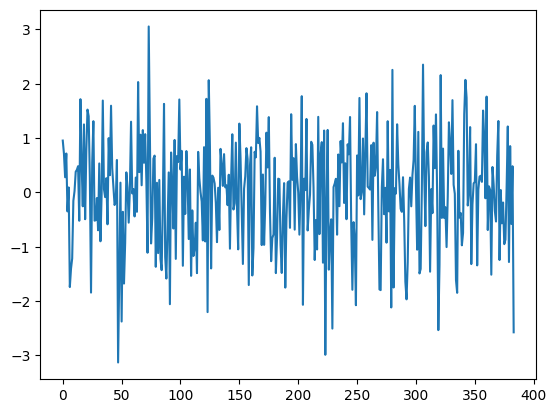

In [90]:
# The transformation of a unit vector by the lreaned adapter matrix.
# Some of the dimenstion are stretched in the positive and some
# in the opposite dimensions. Some are shrinked to 0

test_vector = torch.ones(384)

model.eval()
with torch.no_grad():
    scaled_vector = model(test_vector)

plt.plot(scaled_vector.numpy())
plt.show()

Transform query embedding using the trained adapter matrix

In [77]:
query_embeddings = embedding_function(generated_queries)

input_query_embeddings = torch.Tensor(query_embeddings)

with torch.no_grad():
    adapted_query_embeddings = model(input_query_embeddings).numpy()

projected_query_embeddings = project_embeddings(query_embeddings, umap_transform)
projected_adapted_query_embeddings = project_embeddings(adapted_query_embeddings, umap_transform)

100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


You can see that the adapter matrix shifted results to certain parts of the embedding space.

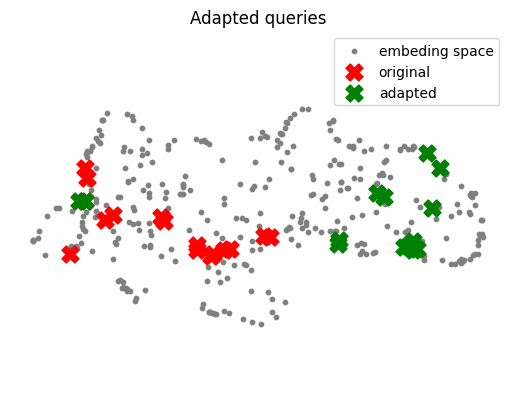

In [78]:
# Plot the projected query and retrieved documents in the embedding space
# Notice how queries are now appearing
layers = [PlotLayer(projected_dataset_embeddings, size=10, color='gray', label="embeding space"),
               PlotLayer(projected_query_embeddings, size=150, marker='X', color='r', label="original"),
               PlotLayer(projected_adapted_query_embeddings, size=150, marker='X', color='green', label="adapted" )]
plot_projections("Adapted queries", layers, ["embeding space", "original", "adapted"])

In [61]:
label_index = 0

for i in range(len(query_embeddings)):
      print("label       orignial similarity   adapted similarity")
      print("-"*60)
      for j in range(len(retrieved_embeddings[i])):

          label = adapter_labels[label_index]

          old_query_embedding = torch.tensor(query_embeddings[i])
          adapted_query = torch.tensor(adapted_query_embeddings[i])

          sim0 = torch.cosine_similarity(old_query_embedding, adapted_query, dim=0).numpy()

          document_embedding = torch.tensor(np.array(retrieved_embeddings[i][j]))

          sim1 = torch.cosine_similarity(old_query_embedding, document_embedding, dim=0).numpy()
          sim2 = torch.cosine_similarity(adapted_query, document_embedding, dim=0).numpy()

          print(label, sim1, sim2)
        
          if label_index < len(adapter_labels)-1:

              label_index += 1

          print("-"*60)


label       orignial similarity   adapted similarity
------------------------------------------------------------
tensor(-1.) 0.5732989511351894 -0.1412449710817114
------------------------------------------------------------
tensor(1.) 0.5565748562849344 0.4417865683362831
------------------------------------------------------------
tensor(1.) 0.5508922804343204 0.5100411206056531
------------------------------------------------------------
tensor(1.) 0.5382811072769018 0.3189831551623042
------------------------------------------------------------
tensor(-1.) 0.5361228632778401 0.05587418216320944
------------------------------------------------------------
tensor(-1.) 0.5344083908585426 0.13188004246149898
------------------------------------------------------------
tensor(1.) 0.5339079388047 0.2438254669817415
------------------------------------------------------------
tensor(1.) 0.5277888274623441 0.5114655250085908
------------------------------------------------------------
ten

Some of the queries are made better and some worse. Play with it and see why?

In [75]:
index = 2
print(word_wrap(generated_queries[index]))
print("")
qe = query_embeddings[index]
results = chroma_collection.query(query_embeddings=qe, n_results=5,
                                  include=['documents', 'embeddings'])
docs = results["documents"]
for d in docs:
    print(word_wrap(d[0]))

3. What is the company's net income for the past year?

37 general and administrative expenses include payroll, employee
benefits, stock - based compensation expense, and other headcount -
related expenses associated with finance, legal, facilities, certain
human resources and other administrative personnel, certain taxes, and
legal and other administrative fees. general and administrative
expenses increased $ 793 million or 16 % driven by investments in
corporate functions. other income ( expense ), net the components of
other income ( expense ), net were as follows : ( in millions ) year
ended june 30, 2022 2021 interest and dividends income $ 2, 094 $ 2,
131 interest expense ( 2, 063 ) ( 2, 346 ) net recognized gains on
investments 461 1, 232 net gains ( losses ) on derivatives ( 52 ) 17
net gains ( losses ) on foreign currency remeasurements ( 75 ) 54
other, net ( 32 ) 98 total $ 333 $ 1, 186


In [76]:
print(word_wrap(generated_queries[index]))
print("")
aqe = adapted_query_embeddings[index].tolist()
results = chroma_collection.query(query_embeddings=aqe, n_results=5,
                                  include=['documents', 'embeddings'])
docs = results["documents"]
for d in docs:
    print(word_wrap(d))

3. What is the company's net income for the past year?

['net income $ 72, 738 $ 61, 271 $ 44, 281 earnings per share : basic $ 9. 70 $ 8. 12 $ 5. 82 diluted $ 9. 65 $ 8. 05 $ 5. 76 weighted average shares outstanding : basic 7, 496 7, 547 7, 610 diluted 7, 540 7, 608 7, 683 refer to accompanying notes.', 'excluding tac, growth revenue from search and news advertising excluding traffic acquisition costs ( “ tac ” ) paid to bing ads network publishers and news partners summary results of operations ( in millions, except percentages and per share amounts ) 2022 2021 percentage change revenue $ 198, 270 $ 168, 088 18 % gross margin 135, 620 115, 856 17 % operating income 83, 383 69, 916 19 % net income 72, 738 61, 271 19 % diluted earnings per share 9. 65 8. 05 20 % adjusted net income ( non - gaap ) 69, 447 60, 651 15 % adjusted diluted earnings per share ( non - gaap ) 9. 21 7. 97 16 % adjusted net income and adjusted diluted earnings per share ( “ eps ” ) are non - gaap financial measu